<div class="alert alert-block alert-info">
⚠️All notebooks should start with the following cell ⚠️.
<br>
<br>
This will ensure that the notebook is set in the correct working directory and that all internal modules can be loaded without setting an entry point.
</div>

In [2]:
from utils import setup_env_path

setup_env_path()

%load_ext autoreload
%autoreload 2

Former working directory:  /workspaces/fil-rouge-pollinisateurs/notebooks
Current working directory:  /workspaces/fil-rouge-pollinisateurs


Setup notebook

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px

In [4]:
path = "data/temporary_data/spipoll.csv"

In [5]:
data = pd.read_csv(path)

/tmp/ipykernel_1088/822284616.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(path)


In [6]:
restricted_vars = [
    "collection_id",
    "plante_sc",
    "plante_fr",
    "insecte_sc",
    "insecte_fr",
    "temperature",
    "vent",
    "latitude",
    "longitude",
    "nebulosite",
    "collection_heure_debut",
]
df = data[restricted_vars].copy()

# Mise en place du modèle



## Pipeline de modélisation

In [7]:
df = data[restricted_vars].copy().sample(frac=0.01, random_state=1)
df.shape

(6757, 11)

In [8]:
from models.supervised.preprocessors import MetricsCalculatorNaive as MetricsCalculator

# Add the target variable to the dataframe

distance = 0.5
calculator = MetricsCalculator(distance=distance, clear_intermediate_steps=True)
calculator.fit(df)
df_transformed = calculator.transform(df)

Calculating metrics...


100%|██████████| 6757/6757 [00:10<00:00, 626.29it/s]


In [9]:
from models.supervised.preprocessors import HourToCos, DateToJulian

# Add hour to cos tranformation and date to julian day transformation
df_transformed = HourToCos(hour_col="collection_heure_debut").fit_transform(
    df_transformed
)
df_transformed = DateToJulian(date_col="collection_heure_debut").fit_transform(
    df_transformed
)

In [10]:
# check that all transformations have been applied
df_transformed.head(2)

,collection_id,plante_sc,plante_fr,insecte_sc,insecte_fr,temperature,vent,latitude,longitude,nebulosite,collection_heure_debut,weighted_specific_richness,collection_heure_debut_cos,collection_heure_debut_julian
172218,19 068,Les Angéliques (Angelica sp),NaN,NaN,Les Mouches difficiles à déterminer,20-30ºC,"faible, irrégulier",48.841331,2.358497,0-25%,2016-05-02 11:30:00.000,0.218035,-0.991445,2.457511e+06
37176,4 091,Daucus carota,Carotte sauvage,Hylaeus,Les Abeilles Hylaeus à taches blanches,20-30ºC,"faible, irrégulier",48.213400,-1.693901,0-25%,2019-07-24 09:30:00.000,0.191677,-0.793353,2.458689e+06


In [11]:
df_transformed.columns

Index(['collection_id', 'plante_sc', 'plante_fr', 'insecte_sc', 'insecte_fr',
       'temperature', 'vent', 'latitude', 'longitude', 'nebulosite',
       'collection_heure_debut', 'weighted_specific_richness',
       'collection_heure_debut_cos', 'collection_heure_debut_julian'],
      dtype='object')

In [12]:
numeric_features = [
    "latitude",
    "longitude",
    "collection_heure_debut_cos",
    "collection_heure_debut_julian",
]

ordinal_features = ["vent", "nebulosite", "temperature"]

nominal_features = [
    "plante_fr",
    # ....
]

categorical_features = ordinal_features + nominal_features

used_features = numeric_features + ordinal_features + nominal_features

In [13]:
X = df_transformed[used_features]
y = df_transformed["weighted_specific_richness"]

In [14]:
X.head()

,latitude,longitude,collection_heure_debut_cos,collection_heure_debut_julian,vent,nebulosite,temperature,plante_fr
172218,48.841331,2.358497,-0.991445,2.457511e+06,"faible, irrégulier",0-25%,20-30ºC,NaN
37176,48.213400,-1.693901,-0.793353,2.458689e+06,"faible, irrégulier",0-25%,20-30ºC,Carotte sauvage
618860,44.717569,4.547003,-0.854912,2.459992e+06,"faible, irrégulier",0-25%,10-20ºC,Laurier tin
316812,46.810336,6.382778,-0.999048,2.456499e+06,"faible, irrégulier",0-25%,20-30ºC,NaN
92345,48.135764,-1.697600,-0.790690,2.458332e+06,"faible, irrégulier",0-25%,20-30ºC,NaN


Il FAUT gérer les données manquantes. Pour ça on va utiliser un KNN qui va chercher les observations les plus proches pour compléter les données manquantes !

https://scikit-learn.org/stable/auto_examples/impute/plot_missing_values.html#sphx-glr-auto-examples-impute-plot-missing-values-py

In [15]:
# idée: utiliser un KNN modifié pour remplacer les données par les plus proches spatialement !

In [16]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from models.supervised.preprocessors import HourToCos, DateToJulian

numeric_pipeline = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("imputer", KNNImputer(n_neighbors=5)),
    ]
)

# make a pipeline for the categorical features (that combines ordinal and nominal)
categorical_pipeline = Pipeline(
    steps=[
        (
            "encoding",
            ColumnTransformer(
                transformers=[
                    (
                        "ordinal",
                        Pipeline(
                            steps=[
                                ("imputer", SimpleImputer(strategy="most_frequent")),
                                ("encoder", OrdinalEncoder()),
                            ]
                        ),
                        ordinal_features,
                    ),
                    (
                        "nominal",
                        Pipeline(
                            steps=[
                                ("imputer", SimpleImputer(strategy="most_frequent")),
                                ("encoder", OneHotEncoder(handle_unknown="ignore")),
                            ]
                        ),
                        nominal_features,
                    ),
                ],
                remainder="drop",
            ),
        ),
    ]
)


preprocessor = ColumnTransformer(
    transformers=[
        ("numerical", numeric_pipeline, numeric_features),
        ("categorical", categorical_pipeline, categorical_features),
    ],
    remainder="drop",
)

estimator = RandomForestRegressor(random_state=1)

# estimator = LinearRegression()

pipe = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("estimator", estimator),
    ]
)
pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('imputer',
                                                                   KNNImputer())]),
                                                  ['latitude', 'longitude',
                                                   'collection_heure_debut_cos',
                                                   'collection_heure_debut_julian']),
                                                 ('categorical',
                                                  Pipeline(steps=[('encoding',
                                                                   ColumnTransformer(transformers=[('ordinal',
                                                                                                    Pipeline(steps=[('imputer',
                                                                                                                     Si...rategy='most_frequent')),
                                                                                                                    ('encoder',
                                                                                                                     OrdinalEncoder())]),
                                                                                                    ['vent',
                                                                                                     'nebulosite',
                                                                                                     'temperature']),
                                                                                                   ('nominal',
                                                                                                    Pipeline(steps=[('imputer',
                                                                                                                     SimpleImputer(strategy='most_frequent')),
                                                                                                                    ('encoder',
                                                                                                                     OneHotEncoder(handle_unknown='ignore'))]),
                                                                                                    ['plante_fr'])]))]),
                                                  ['vent', 'nebulosite',
                                                   'temperature',
                                                   'plante_fr'])])),
                ('estimator', RandomForestRegressor(random_state=1))])

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [18]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('imputer',
                                                                   KNNImputer())]),
                                                  ['latitude', 'longitude',
                                                   'collection_heure_debut_cos',
                                                   'collection_heure_debut_julian']),
                                                 ('categorical',
                                                  Pipeline(steps=[('encoding',
                                                                   ColumnTransformer(transformers=[('ordinal',
                                                                                                    Pipeline(steps=[('imputer',
                                                                                                                     Si...rategy='most_frequent')),
                                                                                                                    ('encoder',
                                                                                                                     OrdinalEncoder())]),
                                                                                                    ['vent',
                                                                                                     'nebulosite',
                                                                                                     'temperature']),
                                                                                                   ('nominal',
                                                                                                    Pipeline(steps=[('imputer',
                                                                                                                     SimpleImputer(strategy='most_frequent')),
                                                                                                                    ('encoder',
                                                                                                                     OneHotEncoder(handle_unknown='ignore'))]),
                                                                                                    ['plante_fr'])]))]),
                                                  ['vent', 'nebulosite',
                                                   'temperature',
                                                   'plante_fr'])])),
                ('estimator', RandomForestRegressor(random_state=1))])

In [19]:
pipe.predict(X_test)

array([0.19246368, 0.34072267, 0.25307043, ..., 0.6353693 , 0.19167718,
       0.25303592])

In [20]:
# make all the scores for regression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = pipe.predict(X_test)

print(f"Mean squared error: {mean_squared_error(y_test, y_pred):.2f}")
print(f"Mean absolute error: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"R2 score: {r2_score(y_test, y_pred):.2f}")

Mean squared error: 0.00
Mean absolute error: 0.01
R2 score: 0.97


In [21]:
# Cluncky way to get feature importance, not prone to change !!!!

importance = pipe.named_steps["estimator"].feature_importances_
# use passthrough step to get the features names
feature_names = (
    pipe.named_steps["preprocessor"]
    .transformers_[1][1]
    .named_steps["encoding"]
    .get_feature_names_out(input_features=categorical_features)
)
feature_names = np.concatenate([numeric_features, feature_names])

feature_importance = pd.DataFrame(
    {"feature": feature_names, "importance": importance}
).sort_values("importance", ascending=False)

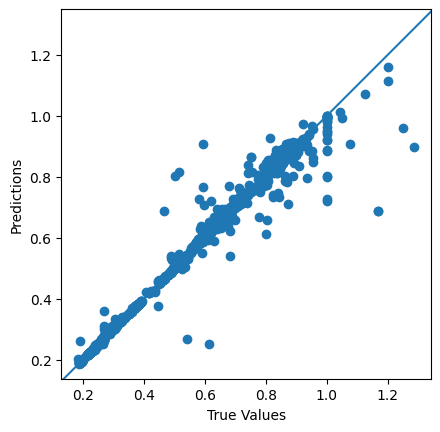

In [22]:
# plot y_test vs y_pred
plt.scatter(y_test, y_pred)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.axis("square")
_ = plt.plot([-100, 100], [-100, 100])

## Prediction sur carte France métropolitaine

In [23]:
france_data = pd.read_csv("data/temporary_data/france_place_modele.csv", sep=";")
france_data = france_data.sample(frac=0.1, random_state=1)

In [24]:
france_data.rename(
    columns={
        "lat": "latitude",
        "long": "longitude",
    },
    inplace=True,
)

In [25]:
# create columns if not existent from used_features

for col in used_features:
    if col not in france_data.columns:
        france_data[col] = np.nan

In [26]:
france_data = france_data[used_features]

In [27]:
france_data[used_features]
france_data["results"] = pipe.predict(france_data[used_features])

/tmp/ipykernel_1088/1752008247.py:12: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  france = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


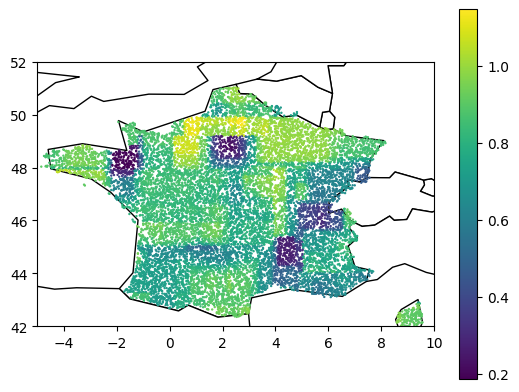

In [28]:
# plot the predictions in france map with the data knowing that france_data has lat and long
# use a map contour  
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns


# Assuming your DataFrame is named df and has columns "latitude", "longitude", and "results"
gdf = gpd.GeoDataFrame(france_data, geometry=gpd.points_from_xy(france_data.longitude, france_data.latitude))

# Load the map of France
france = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
france_boundary = france.unary_union

# Plot the map of France
ax = france.plot(color='white', edgecolor='black')

# Plot the results on the map
gdf.plot(ax=ax, column='results', legend=True, markersize=0.5)

# Set the bounding box to focus on France
ax.set_xlim(-5, 10)  # Longitude limits for France
ax.set_ylim(42, 52)  # Latitude limits for France


# Show the plot
plt.show()



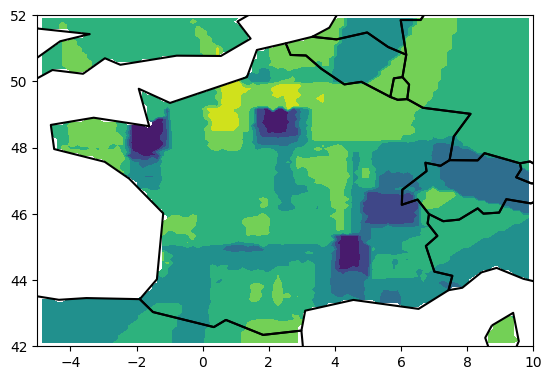

In [29]:
from shapely.geometry import box, Point
from scipy.interpolate import griddata

# Define the grid for interpolation
x = gdf['longitude']
y = gdf['latitude']
z = france_data['results']

# Create a grid of points within the bounding box of France
x_grid, y_grid = np.mgrid[-5:10:100j, 42:52:100j]

# Interpolate the data values on the grid
z_grid = griddata((x, y), z, (x_grid, y_grid), method='nearest')

# Get the boundary of metropolitan France
france_boundary = france.unary_union

# Create a bounding box for metropolitan France
bbox = box(minx=-5, miny=42, maxx=10, maxy=52)

# Create the mask for metropolitan France
mask = bbox.intersection(france_boundary)

# Create individual points for the mask
points = np.column_stack((x_grid.ravel(), y_grid.ravel()))
mask_values = np.array([mask.contains(Point(p)) for p in points])
mask_values = mask_values.reshape(x_grid.shape)

# Apply the mask to the interpolated data and plot
masked_data = np.where(mask_values, z_grid, np.nan)
plt.contourf(x_grid, y_grid, masked_data, cmap='viridis')

france.boundary.plot(ax=plt.gca(), color='black')
# Set the bounding box to focus on France
plt.xlim(-5, 10)  # Longitude limits for France
plt.ylim(42, 52)  # Latitude limits for France


# Show the plot
plt.show()